<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/TimeSeries_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
#from sympy import Derivative
import numpy as np
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 저장된 삼성전자(KR7005930003) 데이터 가져오기

data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'
with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file) 

In [4]:
# 저장된 삼성전자(KR7005930003) 데이터 가져오기
df = pd.read_json(json_data['KR7005930003'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2021/11/05,005930,삼성전자,"70,200","71,600","71,600","70,200","419,078,735,010,000","12,667,743","3,841",18.28,"39,406",1.78,"2,994",4.26
1,2021/11/04,005930,삼성전자,"70,600","71,200","71,600","70,500","421,466,648,030,000","11,818,987","3,841",18.38,"39,406",1.79,"2,994",4.24
2,2021/11/03,005930,삼성전자,"70,400","71,700","71,700","70,100","420,272,691,520,000","12,770,428","3,841",18.33,"39,406",1.79,"2,994",4.25
3,2021/11/02,005930,삼성전자,"71,500","70,800","72,200","70,700","426,839,452,325,000","16,812,570","3,841",18.61,"39,406",1.81,"2,994",4.19
4,2021/11/01,005930,삼성전자,"69,900","70,200","70,600","69,900","417,287,800,245,000","11,503,729","3,841",18.20,"39,406",1.77,"2,994",4.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,1995/05/08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000","91,810",-,-,-,-,-,-
6712,1995/05/06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000","47,440",-,-,-,-,-,-
6713,1995/05/04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500","175,590",-,-,-,-,-,-
6714,1995/05/03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500","382,980",-,-,-,-,-,-


In [5]:
#시간 순 재정렬.
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

#시가총액 str->float 데이터타입변환
samsung['MKTCAP'] = samsung['MKTCAP'].str.replace(',','').astype('float')


#7월부터 10월 20일까지만 추출
samsung01 = samsung[['TRD_DD','MKTCAP']]

samsung01= samsung01[(samsung01['TRD_DD']>='2017-01-01') & (samsung01['TRD_DD']<='2021-10-20')]
samsung01 = samsung01.rename(columns = {'TRD_DD':'x','MKTCAP':'y'})
samsung01.reset_index(drop=True,inplace=True)
samsung01

,x,y
0,2017-01-02,2.539262e+14
1,2017-01-03,2.565991e+14
2,2017-01-04,2.543482e+14
3,2017-01-05,2.501279e+14
4,2017-01-06,2.546296e+14
...,...,...
1173,2021-10-14,4.143029e+14
1174,2021-10-15,4.184818e+14
1175,2021-10-18,4.190787e+14
1176,2021-10-19,4.214666e+14


In [6]:
# 기울기 양->음, 음->양 지점 추출하기.
samsung01['ch'] = np.nan
samsung01['ch_result'] = np.nan

for i in range(samsung01.shape[0]-1):
  y2 = samsung01.iloc[i+1,1]
  y1 = samsung01.iloc[i,1]

  if (y2-y1>=0):
    samsung01.iloc[i,2] = 1
  else:
    samsung01.iloc[i,2] = 0
    
for i in range(samsung01.shape[0]-1):  
  check = samsung01.iloc[i,2] != samsung01.iloc[i+1,2]
  if(check):
    samsung01.iloc[i+1,3]= True
  else:
    samsung01.iloc[i+1,3]= False

check = samsung01[samsung01['ch_result']==True]
check.reset_index(drop=True, inplace= True)


In [7]:
#두 점 사이 df 
def two_point(check):
  df = check[['x']]
  df= df.iloc[:-1]
  df['x2'] = np.nan
  df['y1'] = np.nan
  df['y2'] = np.nan
  df.rename(columns ={'x':'x1'}, inplace = True)
  df['t'] = np.nan
  df['p'] = 0.0

  for i in range(df.shape[0]):
  
    df.iloc[i,1] = check.iloc[i+1,0]
    df.iloc[i,2] = check.iloc[i,1]
    df.iloc[i,3] = check.iloc[i+1,1]

  for i in range(df.shape[0]):
    t = df.iloc[i,1] - df.iloc[i,0]
    df.iloc[i,4] = t.days

    y1 = df.iloc[i,2]
    y2 = df.iloc[i,3]
    result = (abs(y2 - y1 )) / ((y1+y2)/2 )
    df.iloc[i,5] = result

  df['m'] = np.nan
  for i in range(df.shape[0]):
    m = df.iloc[i,3]- df.iloc[i,2] 
  
    if (m>0):
      df.iloc[i,6] = 1
    elif (m<0):
      df.iloc[i,6] = -1
    else :
      df.iloc[i,6] = 0

  return df

#조건 필터링 
def p_t(df):
  t = df['t'] <5
  p = df['p']<0.05

  result = df[~t&~p]
  return result

In [8]:
df = two_point(check)
result = p_t(df)
result

,x1,x2,y1,y2,t,p,m
1,2017-01-05,2017-01-12 00:00:00,2.501279e+14,2.729179e+14,7.0,0.087144,1.0
7,2017-01-20,2017-01-26 00:00:00,2.616636e+14,2.806553e+14,6.0,0.070039,1.0
21,2017-03-10,2017-03-17 00:00:00,2.826248e+14,2.982402e+14,7.0,0.053766,1.0
32,2017-04-13,2017-04-20 00:00:00,2.983809e+14,2.833282e+14,7.0,0.051753,-1.0
33,2017-04-20,2017-05-08 00:00:00,2.833282e+14,3.283391e+14,18.0,0.147175,1.0
61,2017-07-07,2017-07-13 00:00:00,3.126897e+14,3.303300e+14,6.0,0.054867,1.0
66,2017-07-20,2017-07-28 00:00:00,3.345113e+14,3.120364e+14,8.0,0.069523,-1.0
71,2017-08-11,2017-08-17 00:00:00,2.895135e+14,3.052155e+14,6.0,0.052804,1.0
77,2017-09-04,2017-09-11 00:00:00,2.987271e+14,3.231236e+14,7.0,0.078464,1.0
79,2017-09-12,2017-09-18 00:00:00,3.218259e+14,3.405125e+14,6.0,0.056426,1.0


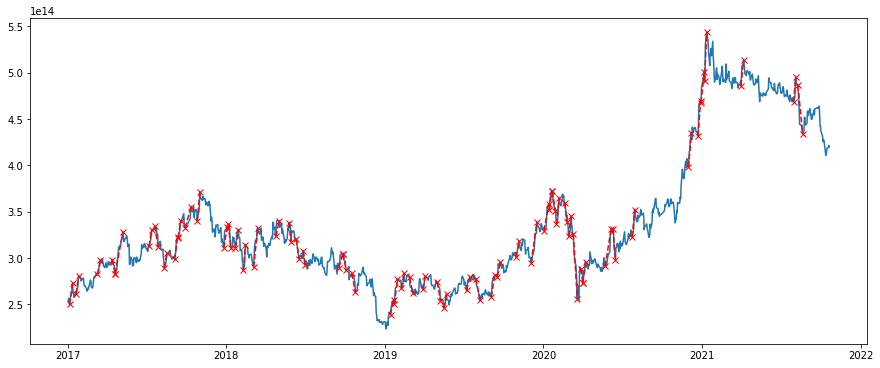

In [9]:
x1 = list(df.iloc[0,:2])
y1 = list(df.iloc[0,2:4])

plt.figure(figsize=(15,6))
plt.plot(samsung01['x'],samsung01['y'])
#plt.plot(x,y, color = "orange", linestyle = "--")
#plt.scatter(x,y)
for i in range(result.shape[0]):
  x1 = list(result.iloc[i,:2])
  y1 = list(result.iloc[i,2:4])
  plt.plot(x1,y1, "rx--")
plt.show()

In [10]:
#빨간 점 X 뽑아내기

red_x = list(result['x1'])+ list(result['x2'])
red_x = list(set(red_x))
red_x.sort()
red_x

red = samsung01[samsung01.x == red_x[0]]

for i in red_x:
  df = samsung01[samsung01.x == i]
  red = red.append(df,ignore_index = True )

red = red.iloc[1:,:]

#빨간 점들끼리 조건 확인.

df1=two_point(red)
result2=p_t(df1)


In [11]:
# 조건 충족할 때까지 while문 실행.
while True:
  
  exitOuterLoop = False
  count = 0

  #조건에 만족하는 빨간점 추출.
  red_x1 = list(result2['x1'])+ list(result2['x2'])
  red_x1 = list(set(red_x1))
  red_x1.sort()  

  for i in range(result2.shape[0]-1):
    a = result2.iloc[i,1] == result2.iloc[i+1,0]
    b = result2.iloc[i,6]* result2.iloc[i+1,6]== -1

    if(a&b ) :
      count+=1
    
    if (count ==  result2.shape[0]-1 ):
      print("조건 성립 완료")
      exitOuterLoop = True
      break
  if (exitOuterLoop ):
    break
      
  for i in range(result2.shape[0]-1):

    #i번째 기울기 음수일때
    if (result2.iloc[i,6]== -1):  
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if(result2.iloc[i,3]> result2.iloc[i+2,2]):
            red_x1.remove(result2.iloc[i,1])
          else :
            red_x1.remove(result2.iloc[i+1,0]) 
            


      #i+1번째 기울기 음수일 때
      elif (result2.iloc [i+1,6]== -1):       
        red_x1.remove(result2.iloc[i,1])


    #i번째 기울기 양수일때
    else :   
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          red_x1.remove(result2.iloc[i,1])
          red_x1.remove(result2.iloc[i+1,0]) 
        #점이 이어져 있으면
        else :
          red_x1.remove(result2.iloc[i,1])
      #i+1번째 기울기 음수일 때
      else :
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if (result2.iloc[i,3]>=result2.iloc[i+1,2]):
            red_x1.remove(result2.iloc[i+1,0])
          else:
            red_x1.remove(result2.iloc[i,1])
     
  final = samsung01[samsung01.x == red_x1[0]]

  for i in red_x1:
    df = samsung01[samsung01.x == i]
    final = final.append(df,ignore_index = True )

  final = final.iloc[1:,:]

  df1=two_point(final)
  result2=p_t(df1)
  result2




조건 성립 완료


(736330.0, 738083.0)

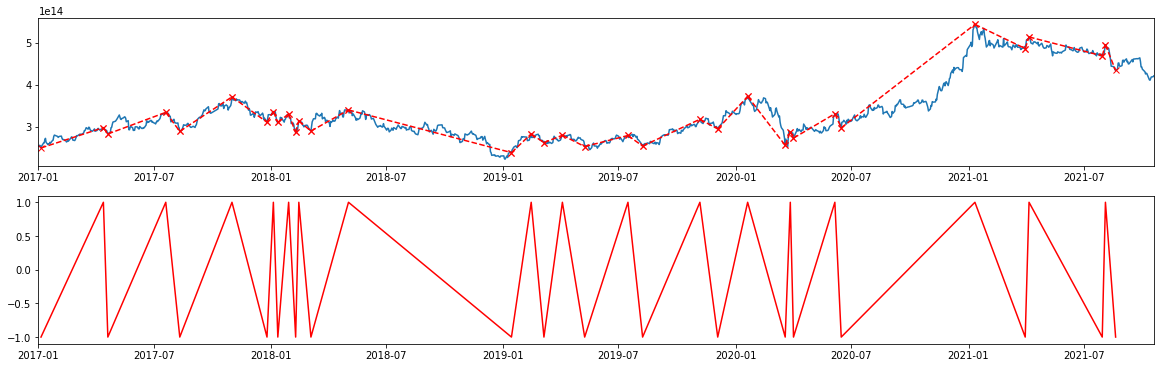

In [15]:
# trend -1~1로 변환.
final = samsung01[samsung01.x == red_x1[0]]

for i in red_x1:
  df = samsung01[samsung01.x == i]
  final = final.append(df,ignore_index = True )

final = final.iloc[1:,:2]


for i in range(final.shape[0]-1):
  if(result2.iloc[i,6]== 1):
    final.iloc[i,1] = -1
  else :
    final.iloc[i,1] = 1

#final =final[1:final.shape[0]-1]
n = final.shape[0]-2
if(final.iloc[n,1]== -1):
  final.iloc[final.shape[0]-1,1] = 1
else:
  final.iloc[final.shape[0]-1,1] = -1


#그림으로 확인하기.
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax1.plot(samsung01['x'],samsung01['y'])
ax1.set_xlim([datetime.date(2017, 1, 1), datetime.date(2021, 10, 20)])
#ax1.plot(x,y, color = "orange", linestyle = "--")

for i in range(result2.shape[0]):
  x1 = list(result2.iloc[i,:2])
  y1 = list(result2.iloc[i,2:4])
  ax1.plot(x1,y1, "rx--")


ax2.plot(final['x'],final['y'], color = "red")
ax2.set_xlim([datetime.date(2017, 1, 1), datetime.date(2021, 10, 20)])
